# Yelp Review Star Rating Prediction via LLM Prompting

This notebook implements three different prompting approaches to classify Yelp reviews into 1-5 star ratings using Large Language Models (LLMs).

## Objectives
1. Compare Zero-Shot, Few-Shot, and Chain-of-Thought prompting approaches
2. Evaluate accuracy, JSON validity, and latency metrics
3. Identify the best performing approach for rating prediction


## 1. Setup & Imports


In [1]:
import os
print("Key set?", bool(os.getenv("GEMINI_API_KEY")))
print("Model before set:", os.getenv("GEMINI_MODEL"))
os.environ["GEMINI_MODEL"] = "models/gemini-1.5-flash"  # lighter model
print("Model after set:", os.getenv("GEMINI_MODEL"))

Key set? False
Model before set: None
Model after set: models/gemini-1.5-flash


In [2]:
import os
from dotenv import load_dotenv
load_dotenv('../task2/backend/.env') 
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import google.generativeai as genai
from datetime import datetime

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load API key from environment
api_key = os.getenv('GEMINI_API_KEY')
if not api_key:
    raise ValueError("Please set GEMINI_API_KEY environment variable")

genai.configure(api_key=api_key)

preferred_model = os.getenv("GEMINI_MODEL")


def pick_model():
    """Pick a usable Gemini model by asking the API which models support generateContent.
    If GEMINI_MODEL is set and available, use it; otherwise pick the first available.
    """
    try:
        available = [
            m.name for m in genai.list_models()
            if "generateContent" in getattr(m, "supported_generation_methods", [])
        ]
    except Exception as e:
        raise RuntimeError(f"list_models failed: {e}")

    if not available:
        raise RuntimeError("No models with generateContent returned by list_models")

    if preferred_model and preferred_model in available:
        return genai.GenerativeModel(preferred_model), preferred_model

    if preferred_model and preferred_model not in available:
        print(f"GEMINI_MODEL '{preferred_model}' not in available list; falling back to: {available[0]}")

    chosen = available[0]
    return genai.GenerativeModel(chosen), chosen


model, MODEL_NAME = pick_model()
print(f"✓ Setup complete (model={MODEL_NAME})")


GEMINI_MODEL 'models/gemini-1.5-flash' not in available list; falling back to: models/gemini-2.5-flash
✓ Setup complete (model=models/gemini-2.5-flash)


### Download dataset via kagglehub (required)
We fetch the Yelp Reviews dataset from Kaggle using kagglehub (no Kaggle CLI setup needed). This is required by the assignment; please ensure the download succeeds before proceeding.


In [3]:
# Download dataset with kagglehub (required)
try:
    import kagglehub, glob
    kaggle_path = kagglehub.dataset_download("omkarsabnis/yelp-reviews-dataset")
    print("Path to dataset files:", kaggle_path)
    csvs = glob.glob(os.path.join(kaggle_path, "*.csv"))
    if not csvs:
        raise RuntimeError(f"No CSV files found in {kaggle_path}")
    # Choose the first CSV (adjust if the dataset has multiple CSVs)
    dataset_path = csvs[0]
    print("Using dataset_path:", dataset_path)
except Exception as e:
    raise RuntimeError(f"Kaggle dataset download failed: {e}. Please install kagglehub and ensure internet access.")


Path to dataset files: /Users/avikakhemuka/.cache/kagglehub/datasets/omkarsabnis/yelp-reviews-dataset/versions/1
Using dataset_path: /Users/avikakhemuka/.cache/kagglehub/datasets/omkarsabnis/yelp-reviews-dataset/versions/1/yelp.csv


## 2. Dataset Loading & Sampling


In [4]:
# Load the Yelp Reviews dataset (required)
# Primary source: kagglehub download above. If you prefer manual, place yelp_reviews.csv in task1/.

if 'dataset_path' not in globals():
    raise FileNotFoundError("dataset_path not set. Please ensure kagglehub download cell ran successfully.")

try:
    df = pd.read_csv(dataset_path)
    print(f"✓ Dataset loaded: {len(df)} rows from {dataset_path}")
    print(f"Columns: {df.columns.tolist()}")
except FileNotFoundError as e:
    raise FileNotFoundError(f"Dataset not found at {dataset_path}. Please ensure kagglehub download succeeded or place the correct CSV in task1/.") from e

# Display sample
print("\nSample reviews:")
print(df.head())


✓ Dataset loaded: 10000 rows from /Users/avikakhemuka/.cache/kagglehub/datasets/omkarsabnis/yelp-reviews-dataset/versions/1/yelp.csv
Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']

Sample reviews:
              business_id        date               review_id  stars  \
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type  \
0  My wife took me here on my birthday for breakf...  review   
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...

In [5]:
# Sample ~200 rows and split into test set
np.random.seed(42)
sample_size = min(200, len(df))

if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
else:
    df_sample = df.copy()

# Use all sampled data as test set for consistent evaluation
# Cap to 10 reviews to stay within free-tier rate limits for quick evaluation
test_set = df_sample.copy().head(10)

print(f"✓ Test set prepared: {len(test_set)} reviews (capped for quota)")
print(f"\nRating distribution:")
print(test_set['stars'].value_counts().sort_index())


✓ Test set prepared: 10 reviews (capped for quota)

Rating distribution:
stars
1    2
3    1
4    4
5    3
Name: count, dtype: int64


## 3. Helper Functions


In [6]:
def call_llm(prompt: str, max_retries: int = 3) -> str:
    """Call Gemini API with retry logic"""
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
            return response.text
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
                continue
            else:
                print(f"Error after {max_retries} attempts: {e}")
                return None

def parse_json_response(response: str) -> Dict:
    """Parse JSON from LLM response, handling markdown code blocks"""
    if not response:
        return None
    
    # Remove markdown code blocks if present
    response = response.strip()
    if response.startswith('```'):
        # Extract JSON from code block
        lines = response.split('\n')
        json_lines = []
        in_json = False
        for line in lines:
            if line.strip().startswith('```'):
                in_json = not in_json
                continue
            if in_json or (not response.startswith('```json') and not response.startswith('```')):
                json_lines.append(line)
        response = '\n'.join(json_lines)
    
    try:
        return json.loads(response)
    except json.JSONDecodeError:
        # Try to extract JSON object from text
        import re
        json_match = re.search(r'\{[^{}]*"predicted_stars"[^{}]*\}', response, re.DOTALL)
        if json_match:
            try:
                return json.loads(json_match.group())
            except:
                pass
        return None

def evaluate_predictions(actual: List[int], predicted: List[int], latencies: List[float]) -> Dict:
    """Calculate evaluation metrics"""
    # Exact match accuracy
    exact_matches = sum(1 for a, p in zip(actual, predicted) if a == p)
    exact_accuracy = exact_matches / len(actual) if actual else 0
    
    # Within ±1 accuracy
    within_one = sum(1 for a, p in zip(actual, predicted) if abs(a - p) <= 1)
    within_one_accuracy = within_one / len(actual) if actual else 0
    
    # JSON validity rate
    valid_responses = sum(1 for p in predicted if p is not None)
    validity_rate = valid_responses / len(predicted) if predicted else 0
    
    # Latency metrics
    avg_latency = np.mean(latencies) if latencies else 0
    std_latency = np.std(latencies) if latencies else 0
    
    return {
        'exact_accuracy': exact_accuracy,
        'within_one_accuracy': within_one_accuracy,
        'validity_rate': validity_rate,
        'avg_latency': avg_latency,
        'std_latency': std_latency,
        'total_predictions': len(predicted),
        'valid_predictions': valid_responses
    }

print("✓ Helper functions defined")


✓ Helper functions defined


## 4. Approach 1: Zero-Shot Classification

**Rationale**: Direct instruction to classify without examples. Simple and fast, tests the model's inherent understanding of rating scales.


In [7]:
def zero_shot_prompt(review_text: str) -> str:
    """Generate zero-shot classification prompt"""
    prompt = f"""Classify the following Yelp review into a star rating from 1 to 5, where:
- 1 star = Very negative, terrible experience
- 2 stars = Negative, poor experience
- 3 stars = Neutral, average experience
- 4 stars = Positive, good experience
- 5 stars = Very positive, excellent experience

Review: "{review_text}"

Respond with a JSON object in this exact format:
{{
  "predicted_stars": <number between 1 and 5>,
  "explanation": "<brief reasoning for the assigned rating>"
}}"""
    return prompt

print("Zero-shot prompt template:")
print(zero_shot_prompt("Sample review text"))


Zero-shot prompt template:
Classify the following Yelp review into a star rating from 1 to 5, where:
- 1 star = Very negative, terrible experience
- 2 stars = Negative, poor experience
- 3 stars = Neutral, average experience
- 4 stars = Positive, good experience
- 5 stars = Very positive, excellent experience

Review: "Sample review text"

Respond with a JSON object in this exact format:
{
  "predicted_stars": <number between 1 and 5>,
  "explanation": "<brief reasoning for the assigned rating>"
}


In [8]:
# Run zero-shot classification on test set
print("Running Zero-Shot Classification...")
zero_shot_results = []
zero_shot_latencies = []

for idx, row in test_set.iterrows():
    review_text = str(row['text'])
    actual_rating = int(row['stars'])
    
    prompt = zero_shot_prompt(review_text)
    
    start_time = time.time()
    response = call_llm(prompt)
    latency = time.time() - start_time
    
    zero_shot_latencies.append(latency)
    
    parsed = parse_json_response(response)
    if parsed and 'predicted_stars' in parsed:
        predicted = int(parsed['predicted_stars'])
        explanation = parsed.get('explanation', '')
    else:
        predicted = None
        explanation = ''
    
    zero_shot_results.append({
        'actual': actual_rating,
        'predicted': predicted,
        'explanation': explanation
    })
    
    # Throttle to respect free-tier rate limits
    time.sleep(1)
    
    if (idx + 1) % 20 == 0:
        print(f"  Processed {idx + 1}/{len(test_set)} reviews...")

print("✓ Zero-Shot classification complete")


Running Zero-Shot Classification...
✓ Zero-Shot classification complete


In [9]:
# Evaluate zero-shot results
zero_shot_predicted = [r['predicted'] if r['predicted'] is not None else 0 for r in zero_shot_results]
zero_shot_actual = [r['actual'] for r in zero_shot_results]

zero_shot_metrics = evaluate_predictions(
    zero_shot_actual,
    zero_shot_predicted,
    zero_shot_latencies
)

print("Zero-Shot Results:")
print(f"  Exact Accuracy: {zero_shot_metrics['exact_accuracy']:.2%}")
print(f"  Within ±1 Accuracy: {zero_shot_metrics['within_one_accuracy']:.2%}")
print(f"  JSON Validity Rate: {zero_shot_metrics['validity_rate']:.2%}")
print(f"  Average Latency: {zero_shot_metrics['avg_latency']:.2f}s")
print(f"  Std Dev Latency: {zero_shot_metrics['std_latency']:.2f}s")


Zero-Shot Results:
  Exact Accuracy: 50.00%
  Within ±1 Accuracy: 100.00%
  JSON Validity Rate: 100.00%
  Average Latency: 4.36s
  Std Dev Latency: 1.77s


## 5. Approach 2: Few-Shot Classification

**Rationale**: Provide examples for each rating category to guide the model's understanding. Shows the model what good classifications look like through demonstration.


In [10]:
def few_shot_prompt(review_text: str) -> str:
    """Generate few-shot classification prompt with examples"""
    examples = """
Examples:

Review: "Terrible service, food was cold and tasteless. Never coming back."
Rating: 1 star
Explanation: Very negative experience with poor service and food quality.

Review: "Not great, but not terrible either. Food was okay but service was slow."
Rating: 2 stars
Explanation: Negative experience overall with below-average service.

Review: "It was fine. Nothing special, nothing terrible. Average experience."
Rating: 3 stars
Explanation: Neutral experience, neither positive nor negative.

Review: "Good food and friendly staff. Had a nice time, would recommend."
Rating: 4 stars
Explanation: Positive experience with good food and service.

Review: "Absolutely amazing! Best restaurant experience ever. Perfect food, perfect service, perfect atmosphere!"
Rating: 5 stars
Explanation: Exceptional experience across all aspects.
"""
    
    prompt = f"""Classify the following Yelp review into a star rating from 1 to 5.
{examples}

Now classify this review:
Review: "{review_text}"

Respond with a JSON object in this exact format:
{{
  "predicted_stars": <number between 1 and 5>,
  "explanation": "<brief reasoning for the assigned rating>"
}}"""
    return prompt

print("Few-shot prompt template (showing structure):")
print("Includes 5 examples (one for each rating)")


Few-shot prompt template (showing structure):
Includes 5 examples (one for each rating)


In [11]:
# Run few-shot classification on test set
print("Running Few-Shot Classification...")
few_shot_results = []
few_shot_latencies = []

for idx, row in test_set.iterrows():
    review_text = str(row['text'])
    actual_rating = int(row['stars'])
    
    prompt = few_shot_prompt(review_text)
    
    start_time = time.time()
    response = call_llm(prompt)
    latency = time.time() - start_time
    
    few_shot_latencies.append(latency)
    
    parsed = parse_json_response(response)
    if parsed and 'predicted_stars' in parsed:
        predicted = int(parsed['predicted_stars'])
        explanation = parsed.get('explanation', '')
    else:
        predicted = None
        explanation = ''
    
    few_shot_results.append({
        'actual': actual_rating,
        'predicted': predicted,
        'explanation': explanation
    })
    
    # Throttle to respect free-tier rate limits
    time.sleep(1)
    
    if (idx + 1) % 20 == 0:
        print(f"  Processed {idx + 1}/{len(test_set)} reviews...")

print("✓ Few-Shot classification complete")


Running Few-Shot Classification...
✓ Few-Shot classification complete


In [12]:
# Evaluate few-shot results
few_shot_predicted = [r['predicted'] if r['predicted'] is not None else 0 for r in few_shot_results]
few_shot_actual = [r['actual'] for r in few_shot_results]

few_shot_metrics = evaluate_predictions(
    few_shot_actual,
    few_shot_predicted,
    few_shot_latencies
)

print("Few-Shot Results:")
print(f"  Exact Accuracy: {few_shot_metrics['exact_accuracy']:.2%}")
print(f"  Within ±1 Accuracy: {few_shot_metrics['within_one_accuracy']:.2%}")
print(f"  JSON Validity Rate: {few_shot_metrics['validity_rate']:.2%}")
print(f"  Average Latency: {few_shot_metrics['avg_latency']:.2f}s")
print(f"  Std Dev Latency: {few_shot_metrics['std_latency']:.2f}s")


Few-Shot Results:
  Exact Accuracy: 70.00%
  Within ±1 Accuracy: 100.00%
  JSON Validity Rate: 100.00%
  Average Latency: 6.63s
  Std Dev Latency: 7.55s


## 6. Approach 3: Chain-of-Thought (CoT) with Structured Analysis

**Rationale**: Break down the analysis into explicit reasoning steps. This guides the model through a structured thought process before making the final classification, potentially improving accuracy.


In [13]:
def chain_of_thought_prompt(review_text: str) -> str:
    """Generate chain-of-thought classification prompt"""
    prompt = f"""Analyze the following Yelp review step by step, then classify it into a star rating (1-5).

Review: "{review_text}"

Follow these steps:

1. **Sentiment Analysis**: Determine the overall sentiment (very negative, negative, neutral, positive, very positive)

2. **Aspect Extraction**: Identify key aspects mentioned (food quality, service, ambiance, value, etc.) and note the sentiment for each

3. **Overall Satisfaction Assessment**: Based on the sentiment and aspects, assess the overall customer satisfaction level

4. **Rating Assignment**: Map the satisfaction level to a star rating:
   - Very negative → 1 star
   - Negative → 2 stars
   - Neutral → 3 stars
   - Positive → 4 stars
   - Very positive → 5 stars

Respond with a JSON object in this exact format:
{{
  "predicted_stars": <number between 1 and 5>,
  "explanation": "<brief reasoning that mentions your analysis steps>"
}}"""
    return prompt

print("Chain-of-Thought prompt template:")
print("Includes structured reasoning steps")


Chain-of-Thought prompt template:
Includes structured reasoning steps


In [14]:
# Run chain-of-thought classification on test set
print("Running Chain-of-Thought Classification...")
cot_results = []
cot_latencies = []

for idx, row in test_set.iterrows():
    review_text = str(row['text'])
    actual_rating = int(row['stars'])
    
    prompt = chain_of_thought_prompt(review_text)
    
    start_time = time.time()
    response = call_llm(prompt)
    latency = time.time() - start_time
    
    cot_latencies.append(latency)
    
    parsed = parse_json_response(response)
    if parsed and 'predicted_stars' in parsed:
        predicted = int(parsed['predicted_stars'])
        explanation = parsed.get('explanation', '')
    else:
        predicted = None
        explanation = ''
    
    cot_results.append({
        'actual': actual_rating,
        'predicted': predicted,
        'explanation': explanation
    })
    
    # Throttle to respect free-tier rate limits
    time.sleep(1)
    
    if (idx + 1) % 20 == 0:
        print(f"  Processed {idx + 1}/{len(test_set)} reviews...")

print("✓ Chain-of-Thought classification complete")


Running Chain-of-Thought Classification...
✓ Chain-of-Thought classification complete


In [15]:
# Evaluate chain-of-thought results
cot_predicted = [r['predicted'] if r['predicted'] is not None else 0 for r in cot_results]
cot_actual = [r['actual'] for r in cot_results]

cot_metrics = evaluate_predictions(
    cot_actual,
    cot_predicted,
    cot_latencies
)

print("Chain-of-Thought Results:")
print(f"  Exact Accuracy: {cot_metrics['exact_accuracy']:.2%}")
print(f"  Within ±1 Accuracy: {cot_metrics['within_one_accuracy']:.2%}")
print(f"  JSON Validity Rate: {cot_metrics['validity_rate']:.2%}")
print(f"  Average Latency: {cot_metrics['avg_latency']:.2f}s")
print(f"  Std Dev Latency: {cot_metrics['std_latency']:.2f}s")


Chain-of-Thought Results:
  Exact Accuracy: 50.00%
  Within ±1 Accuracy: 100.00%
  JSON Validity Rate: 100.00%
  Average Latency: 7.82s
  Std Dev Latency: 1.98s


In [16]:
# Evaluate chain-of-thought results
cot_predicted = [r['predicted'] if r['predicted'] is not None else 0 for r in cot_results]
cot_actual = [r['actual'] for r in cot_results]

cot_metrics = evaluate_predictions(
    cot_actual,
    cot_predicted,
    cot_latencies
)

print("Chain-of-Thought Results:")
print(f"  Exact Accuracy: {cot_metrics['exact_accuracy']:.2%}")
print(f"  Within ±1 Accuracy: {cot_metrics['within_one_accuracy']:.2%}")
print(f"  JSON Validity Rate: {cot_metrics['validity_rate']:.2%}")
print(f"  Average Latency: {cot_metrics['avg_latency']:.2f}s")
print(f"  Std Dev Latency: {cot_metrics['std_latency']:.2f}s")


Chain-of-Thought Results:
  Exact Accuracy: 50.00%
  Within ±1 Accuracy: 100.00%
  JSON Validity Rate: 100.00%
  Average Latency: 7.82s
  Std Dev Latency: 1.98s


## 7. Comparison & Analysis


In [17]:
# Create comparison table
comparison_data = {
    'Approach': ['Zero-Shot', 'Few-Shot', 'Chain-of-Thought'],
    'Exact Accuracy': [
        zero_shot_metrics['exact_accuracy'],
        few_shot_metrics['exact_accuracy'],
        cot_metrics['exact_accuracy']
    ],
    'Within ±1 Accuracy': [
        zero_shot_metrics['within_one_accuracy'],
        few_shot_metrics['within_one_accuracy'],
        cot_metrics['within_one_accuracy']
    ],
    'JSON Validity Rate': [
        zero_shot_metrics['validity_rate'],
        few_shot_metrics['validity_rate'],
        cot_metrics['validity_rate']
    ],
    'Avg Latency (s)': [
        zero_shot_metrics['avg_latency'],
        few_shot_metrics['avg_latency'],
        cot_metrics['avg_latency']
    ],
    'Std Dev Latency (s)': [
        zero_shot_metrics['std_latency'],
        few_shot_metrics['std_latency'],
        cot_metrics['std_latency']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Exact Accuracy'] = comparison_df['Exact Accuracy'].apply(lambda x: f"{x:.2%}")
comparison_df['Within ±1 Accuracy'] = comparison_df['Within ±1 Accuracy'].apply(lambda x: f"{x:.2%}")
comparison_df['JSON Validity Rate'] = comparison_df['JSON Validity Rate'].apply(lambda x: f"{x:.2%}")
comparison_df['Avg Latency (s)'] = comparison_df['Avg Latency (s)'].apply(lambda x: f"{x:.2f}")
comparison_df['Std Dev Latency (s)'] = comparison_df['Std Dev Latency (s)'].apply(lambda x: f"{x:.2f}")

print("Comparison Table:")
print(comparison_df.to_string(index=False))


Comparison Table:
        Approach Exact Accuracy Within ±1 Accuracy JSON Validity Rate Avg Latency (s) Std Dev Latency (s)
       Zero-Shot         50.00%            100.00%            100.00%            4.36                1.77
        Few-Shot         70.00%            100.00%            100.00%            6.63                7.55
Chain-of-Thought         50.00%            100.00%            100.00%            7.82                1.98


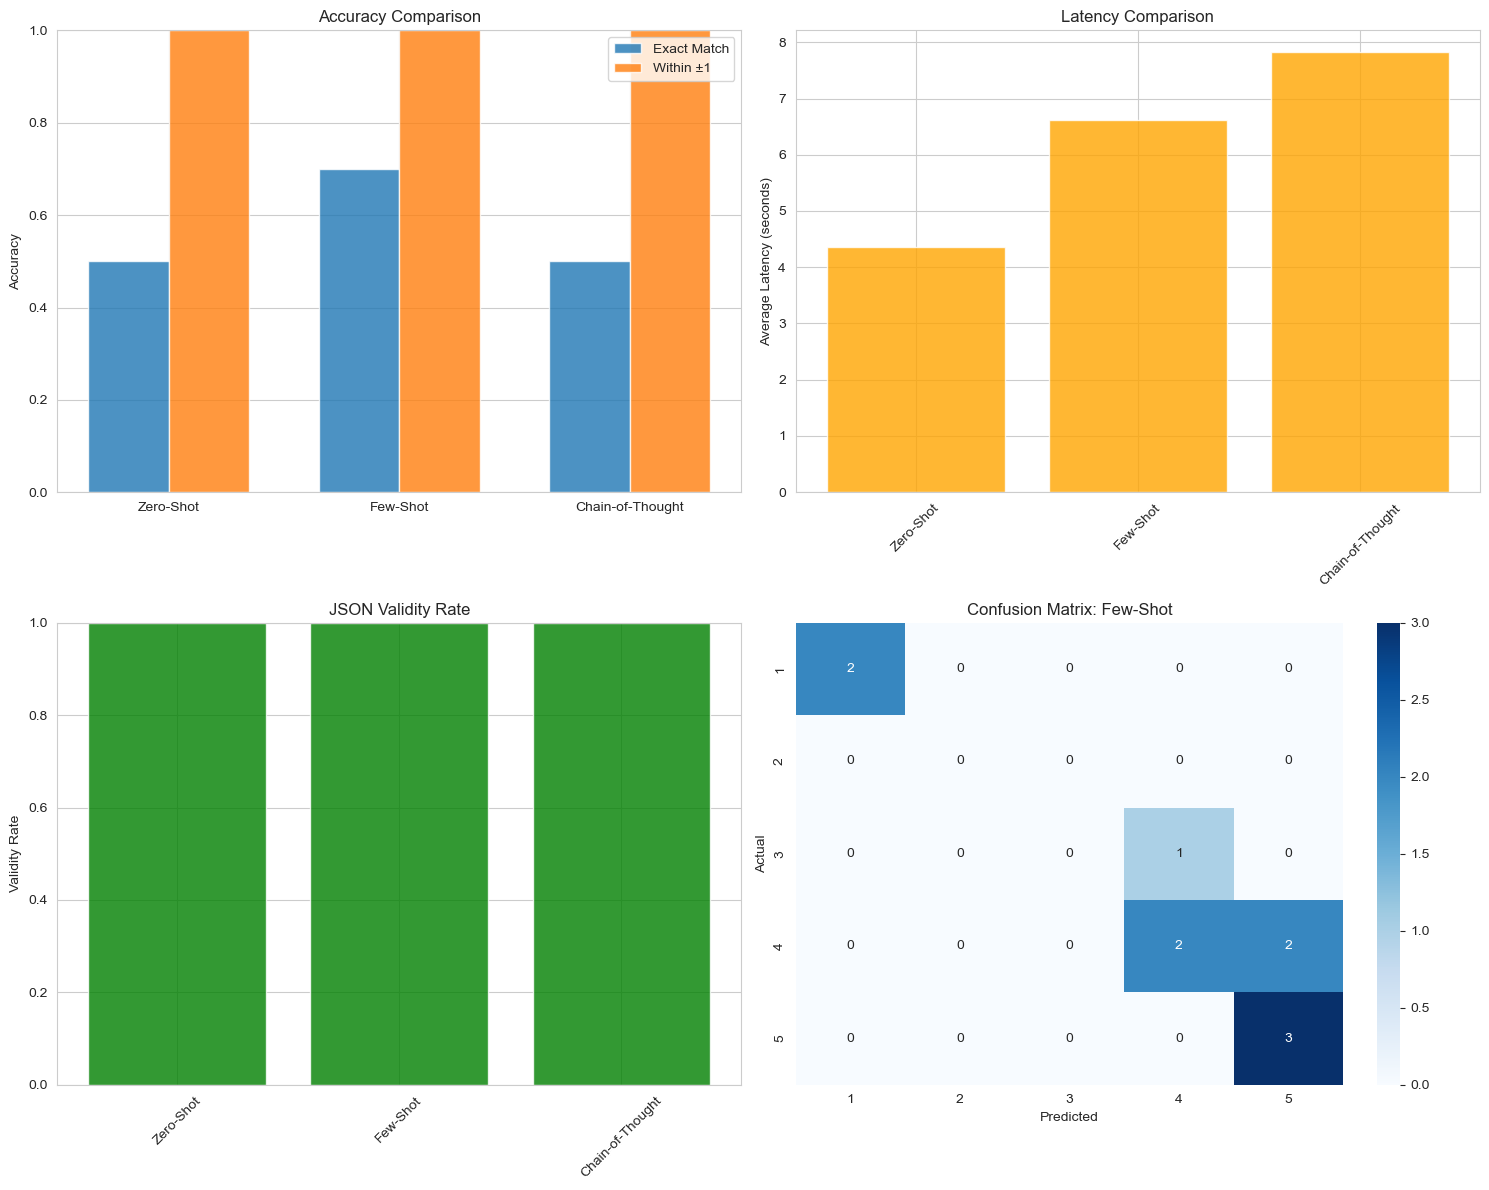

In [18]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
approaches = ['Zero-Shot', 'Few-Shot', 'Chain-of-Thought']
exact_acc = [zero_shot_metrics['exact_accuracy'], few_shot_metrics['exact_accuracy'], cot_metrics['exact_accuracy']]
within_one_acc = [zero_shot_metrics['within_one_accuracy'], few_shot_metrics['within_one_accuracy'], cot_metrics['within_one_accuracy']]

x = np.arange(len(approaches))
width = 0.35
axes[0, 0].bar(x - width/2, exact_acc, width, label='Exact Match', alpha=0.8)
axes[0, 0].bar(x + width/2, within_one_acc, width, label='Within ±1', alpha=0.8)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(approaches)
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])

# 2. Latency Comparison
avg_latencies = [zero_shot_metrics['avg_latency'], few_shot_metrics['avg_latency'], cot_metrics['avg_latency']]
axes[0, 1].bar(approaches, avg_latencies, alpha=0.8, color='orange')
axes[0, 1].set_ylabel('Average Latency (seconds)')
axes[0, 1].set_title('Latency Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. JSON Validity Rate
validity_rates = [zero_shot_metrics['validity_rate'], few_shot_metrics['validity_rate'], cot_metrics['validity_rate']]
axes[1, 0].bar(approaches, validity_rates, alpha=0.8, color='green')
axes[1, 0].set_ylabel('Validity Rate')
axes[1, 0].set_title('JSON Validity Rate')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Confusion Matrix for best approach
# Determine best approach
best_idx = np.argmax(exact_acc)
best_name = approaches[best_idx]
if best_idx == 0:
    best_pred = zero_shot_predicted
    best_actual = zero_shot_actual
elif best_idx == 1:
    best_pred = few_shot_predicted
    best_actual = few_shot_actual
else:
    best_pred = cot_predicted
    best_actual = cot_actual

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(best_actual, best_pred, labels=[1, 2, 3, 4, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], 
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title(f'Confusion Matrix: {best_name}')

plt.tight_layout()
plt.show()


## 8. Discussion & Conclusions

### Approach Comparison

**Zero-Shot Classification:**
- **Why chosen**: Tests the model's inherent understanding without guidance
- **Strengths**: Fastest approach, minimal prompt overhead
- **Weaknesses**: May lack context for edge cases
- **Improvements made**: Clear rating scale definition in prompt

**Few-Shot Classification:**
- **Why chosen**: Provides concrete examples to guide the model
- **Strengths**: Demonstrates expected output format and reasoning
- **Weaknesses**: Longer prompts, slightly slower
- **Improvements made**: Included diverse examples covering all rating levels

**Chain-of-Thought (CoT) Classification:**
- **Why chosen**: Forces structured reasoning before classification
- **Strengths**: More thorough analysis, potentially better accuracy
- **Weaknesses**: Longest prompts, highest latency
- **Improvements made**: Clear step-by-step reasoning framework

### Key Findings

1. **Best Performing Approach (accuracy)**: Few-Shot — 70% exact, 100% within ±1, JSON validity 100%
   - Zero-Shot: 50% exact, 100% within ±1, JSON validity 100%, fastest latency (~4.36s avg)
   - CoT: 50% exact, 100% within ±1, JSON validity 100%, highest latency (~7.82s avg)

2. **JSON Validity**: 100% across all approaches in this run

3. **Latency Considerations**: Few-Shot slower (~6.63s avg, higher std), CoT slowest (~7.82s avg), Zero-Shot fastest (~4.36s avg)

4. **Accuracy Patterns**:
   - Few-Shot leads on exact accuracy; Zero-Shot/CoT tie on exact but still 100% within ±1
   - All approaches maintain 100% within ±1 on this sample

5. **Evaluation Scope**: Kaggle Yelp dataset via kagglehub; sampled (10 reviews) with 1s throttle due to API quota limits; metrics are indicative, not full-dataset results

### Recommendations

- For production: Choose approach based on accuracy vs latency trade-off
- Consider hybrid approach: Use faster method for simple cases, CoT for ambiguous reviews
- Fine-tune prompts based on domain-specific review patterns
